### Imports

In [75]:
from sklearn.metrics import confusion_matrix

In [76]:
from fastai.imports import *
from fastai.structured import *
import numpy as np
import pandas as pd
df = pd.read_csv('data/transform_hot_full.csv', index_col=0)
#df = pd.read_csv('data/transform_hot_mini.csv', index_col=0)

### Helper functions

In [77]:
def split_random_masks(a, n1, n2):
    msk = np.random.rand(len(a)) < (n1 + n2)
    msk1 = ((np.random.rand(len(a)) < n1/(n1+n2)) & msk)
    msk2 = (~msk1 & msk)
    return ~msk, msk1, msk2

def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = ["rmse(trn):",rmse(m.predict(X_train), y_train), " rmse(val):",rmse(m.predict(X_valid), y_valid),
                " scr(trn):",m.score(X_train, y_train), " scr(val):",m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [78]:
m_names = pd.read_csv("exports/game_map_cats.csv",header=None, index_col=0, squeeze=True).to_dict()
map_names = [n for x, n, in m_names.items()]
map_names_swapped = dict([(value, key) for key, value in m_names.items()])

h_names= pd.read_csv("exports/hero_name_cats.csv",header=None, index_col=0, squeeze=True).to_dict()
hero_names = [n for x, n, in h_names.items()]

In [79]:
mns = [x[1] for x in list(enumerate(map_names))]
yhns = ['yours_'+x[1] for x in list(enumerate(hero_names))]
thns = ['theirs_'+x[1] for x in list(enumerate(hero_names))]
col_names =mns+yhns+thns

def hero_one_full(game_map = '', winners = [], losers = []):
    new_row = pd.Series(index = col_names, dtype = 'boolean')
    new_row[:] = False
    for x in hero_names:
        if x in winners:
            new_row['yours_'+x] = True
        if x in losers:
            new_row['theirs_'+x] = True
    new_row[game_map] = True
    return new_row

def hero_hot_mini(game_map = '', winners = [], losers = []):
    new_row = pd.Series(index = hero_names, dtype = 'int8')
    for x in hero_names:
        if x in winners:
            new_row[x] = 2
        if x in losers:
            new_row[x] = 1
    game_map_index = int(map_names_swapped[game_map])
    new_row = new_row.append(pd.Series(game_map_index, index = ['game_map'], dtype = 'int8'))
    return new_row

def hero_one_hot(game_map = '', winners = [], losers = []):
    return hero_one_full(game_map = game_map, winners = winners, losers = losers)

In [80]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

### Training

In [81]:
#testing split function
tr_mask, val_mask, test_mask = split_random_masks(df_trn, val_ratio, tst_ratio)
print("should be zero: ",(tr_mask & val_mask).sum())
print("should be zero: ",(tr_mask & test_mask).sum())
print("should be zero: ",(val_mask & test_mask).sum())
print("should be of dataframe size: ",(tr_mask | val_mask | test_mask).sum())

should be zero:  0
should be zero:  0
should be zero:  0
should be of dataframe size:  5000


#### Prepare X and Y for train and val sets.

In [82]:
train_cats(df)
df_trn, y_trn, nas = proc_df(df, 'outcome')
val_ratio = 0.2
tst_ratio = 0.2
#y_trn=y_trn.astype('bool')
#n_trn = int(len(df_trn) * train_required_ratio)
tr_mask, val_mask, test_mask = split_random_masks(df_trn, val_ratio, tst_ratio)
X_train = df_trn[tr_mask].copy()
y_train = y_trn[tr_mask].copy()

X_valid = df_trn[val_mask].copy()
y_valid = y_trn[val_mask].copy()

X_test = df_trn[test_mask].copy()
y_test = y_trn[test_mask].copy()

print("train: ",X_train.shape, "  val:",X_valid.shape, " tst: ", X_test.shape)
#apply_cats(X_valid, X_train)

train:  (3058, 188)   val: (973, 188)  tst:  (969, 188)


#### Training binary logistic regression model

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression(random_state=0).fit(X_valid, y_valid)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [84]:
game_map = 'Garden of Terror'
game_type = 'UnrankedDraft'
winners=['Auriel', 'Muradin']
losers=['Illidian', 'Abathur']
row = [hero_one_hot(game_map = game_map, winners = winners, losers=losers)]

In [85]:
model.predict(row)

array([ True])

In [86]:
print(model.score(X_valid, y_valid))
print(model.score(X_test, y_test))

0.671120246659815
0.4953560371517028


### Search functions, find best accuracy

#### Define functions

In [87]:
def check_C():
    j = 0
    C_param_range = [0.75,0.9,1,1.1,1.5,2]
    acc_table = pd.DataFrame(columns = ['C_parameter','Accuracy'])
    acc_table['C_parameter'] = C_param_range
    for i in C_param_range:
        # Apply logistic regression model to training data
        lr = LogisticRegression(solver = 'lbfgs', penalty = 'l2', C = i,random_state = 0)
        lr.fit(X_train, y_train)

        # Predict using model
        y_pred = lr.predict(X_test)

        # Saving accuracy score in table
        acc_table.iloc[j,1] = accuracy_score(y_test,y_pred)
        j += 1
    return acc_table

In [100]:
def check_solver():
    j = 0
    S_param_range = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    acc_table = pd.DataFrame(columns = ['Solver','Accuracy'])
    acc_table['Solver'] = S_param_range
    result = %timeit -n1 -r1 -o
    for i in S_param_range:

        # Apply logistic regression model to training data
        lr = LogisticRegression(solver = i, penalty = 'l2', C = 1,random_state = 0) #pen:
        lr.fit(X_train, y_train)

        # Predict using model
        y_pred = lr.predict(X_test)

        # Saving accuracy score in table
        acc_table.iloc[j,1] = accuracy_score(y_test,y_pred)

        j += 1
    return acc_table

In [101]:
def check_penalties():
    j = 0
    P_param_range = ['l1', 'l2', 'elasticnet', 'none']
    acc_table = pd.DataFrame(columns = ['Penalties','Accuracy'])
    acc_table['Penalties'] = P_param_range
    for i in P_param_range:
        # Apply logistic regression model to training data
        lr = LogisticRegression(solver = 'saga', penalty = i, C = 1,random_state = 0, l1_ratio=0.5)
        lr.fit(X_train, y_train)

        # Predict using model
        y_pred = lr.predict(X_test)

        # Saving accuracy score in table
        acc_table.iloc[j,1] = accuracy_score(y_test,y_pred)
        j += 1
    return acc_table

#### Run Optimizers and display results

In [102]:
df1 = check_C()
df2 = check_penalties()
df3 = check_solver()

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1506: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1506: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1506: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty))


In [103]:
display_side_by_side(df1, df2, df3)

,C_parameter,Accuracy
0,0.75,0.515996
1,0.90,0.515996
2,1.00,0.51806
3,1.10,0.51806
4,1.50,0.519092
5,2.00,0.520124
,Penalties,Accuracy
0,l1,0.508772
1,l2,0.51806
2,elasticnet,0.509804


In [104]:
final_model = LogisticRegression(solver = 'saga', penalty = 'l1', C = 1.5,random_state = 0)
final_model.fit(X_train, y_train)

f_pred = final_model.predict(X_test)
print(f_pred.mean(),  f_pred.sum())

0.5356037151702786 519


In [105]:
final_model.score(X_test, y_test)

0.5067079463364293

In [106]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    #ax.set(xticks=np.arange(cm.shape[1]),
    #       yticks=np.arange(cm.shape[0]),
    #       # ... and label them with the respective list entries
    #       xticklabels=classes, yticklabels=classes,
    #       title=title,
    #       ylabel='True label',
    #       xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[235 263]
 [215 256]]


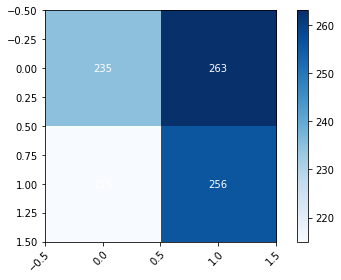

In [107]:
labels = df.outcome
disp = plot_confusion_matrix(y_test, f_pred, labels)
plt.show()